<a href="https://colab.research.google.com/github/MhdAliHarmalani/AI-Projects/blob/main/NoPrivate_SplitNN_vgg_MNIST_tr_ts_class_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional
from torchvision import datasets, transforms, models

from collections import OrderedDict
import csv 
import numpy as np
import pandas as pd

# **Parameters of Opacus**

In [2]:
# !pip install opacus

In [3]:
import warnings
warnings.simplefilter("ignore")

# MAX_GRAD_NORM = 10
# EPSILON = 10.0
# DELTA = 1e-5
EPOCHS = 30

LR = 1e-4

In [4]:
# BATCH_SIZE = 512
# MAX_PHYSICAL_BATCH_SIZE = 128
BATCH_SIZE = 128
# MAX_PHYSICAL_BATCH_SIZE = 64

# **Get the Owner's Dataset**

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
                               transforms.Resize(size=32),
                               transforms.Grayscale(num_output_channels=3),
                               transforms.ToTensor(),
                               transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])

In [6]:
from torchvision.datasets import MNIST

num_of_training_samples=60000
num_of_testing_samples=10000

DATA_ROOT = '/files/'

train_dataset = torchvision.datasets.MNIST(DATA_ROOT, train=True, download=True,
                             transform=transform
                             )

test_dataset = torchvision.datasets.MNIST(DATA_ROOT, train=False, download=True,
                             transform=transform
                             )

train_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size=BATCH_SIZE,
  shuffle=True)

test_loader = torch.utils.data.DataLoader(
  test_dataset,
  batch_size=BATCH_SIZE, 
  shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



In [7]:
# ## load helper.py
# import helper
# sample = iter(train_loader)
# sample_img, sample_target = next(sample)
# print(sample_img[0,:].shape)
# helper.imshow(sample_img[0,:]);
# print(sample_target[0])

# **Setup Vgg16 model**

Setup without Classifier

In [ ]:
# vgg_pretrained = models.vgg16(pretrained=True)

In [ ]:
# vgg_pretrained

In [7]:
class VGG16(torch.nn.Module):
  def __init__(self,pretrained=True):
    super(VGG16, self).__init__()

    # features layers:
    vgg_pretrained_features = models.vgg16(pretrained=True).features
    self.features = torch.nn.Sequential()
    for i in range(31):
      # print(vgg_pretrained_features[i])
      self.features.add_module(str(i), vgg_pretrained_features[i])

    # avgpool layer:
    self.avgpool = models.vgg16(pretrained=True).avgpool

    # # fully conected layers:
    # self.fc6 = nn.Linear(7*7*512, 4096)
    # self.fc7 = nn.Linear(4096, 4096)
    # self.fc8 = nn.Linear(4096, 1000)

  def forward(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    return x
    

In [8]:
vgg16 = VGG16()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [9]:
features_model=vgg16
num_output_features=7*7*512
features_model

VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [10]:
for param in features_model.parameters():
    features_model.requires_grad = False
features_model.eval()

VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
features_model = features_model.to(device)

cpu


# **Get The Features & Labels of training set for Data Scientist** 


In [1]:
# 60000%128

96

In [14]:
# ds=10000
# bs=128
# n= int(ds/bs)-1
# print("n=",n)
# x= int(int(ds/bs)/n)
# x=x*bs*n + (ds%bs) -ds
# x=-x/bs
# x

n= 77


1.0

In [46]:
# int(ds/bs)%n

0

In [15]:
num_of_TRfiles=467
pathTr=[]
for f in range(num_of_TRfiles):
  pathTr.append("featuresAndLabels_training{}.csv".format(f))

In [16]:
#num_of_training_samples=60000
num_of_files=len(pathTr)
num_of_batches_in_one_file= int(int(num_of_training_samples / BATCH_SIZE) /  num_of_files)
print ("num_of_batches_in_one_file: ", num_of_batches_in_one_file)
dl_iter=iter(train_loader)
# j=0

with torch.no_grad():
  for num_of_file in range (num_of_files):
    j=0
    print("move to file:" , num_of_file)
    with open(pathTr[num_of_file], 'a') as csv_file:
      # for j, (images, target) in enumerate (train_loader):
      while( (j) % num_of_batches_in_one_file != 0 or num_of_file==len(pathTr)-1 or j==0):
          try:
            images, target = next(dl_iter)
          except StopIteration:
            break
          print("j=",j)
          images = images.to(device)
          target = target.to(device)
          
          target = target.cpu().detach().numpy()
          target=np.expand_dims(target, axis=0)
          
          pridict = features_model(images)
          pridict= pridict.cpu().detach().numpy()
          pridict= np.squeeze(pridict,axis=None)
          featuresAndLabels=np.concatenate((pridict, target.T), axis=1)###simulate it to sure validation of concatenate

          csv_writer = csv.writer(csv_file , delimiter=',')
          csv_writer.writerows(featuresAndLabels)
          j+=1
      csv_file.close()
        

num_of_batches_in_one_file:  1
move to file: 0
j= 0
move to file: 1
j= 0
move to file: 2
j= 0
move to file: 3
j= 0
move to file: 4
j= 0
move to file: 5
j= 0
move to file: 6
j= 0
move to file: 7
j= 0
move to file: 8
j= 0
move to file: 9
j= 0
move to file: 10
j= 0
move to file: 11
j= 0
move to file: 12
j= 0
move to file: 13
j= 0
move to file: 14
j= 0
move to file: 15
j= 0
move to file: 16
j= 0
move to file: 17
j= 0
move to file: 18
j= 0
move to file: 19
j= 0
move to file: 20
j= 0
move to file: 21
j= 0
move to file: 22
j= 0
move to file: 23
j= 0
move to file: 24
j= 0
move to file: 25
j= 0
move to file: 26
j= 0
move to file: 27
j= 0
move to file: 28
j= 0
move to file: 29
j= 0
move to file: 30
j= 0
move to file: 31
j= 0
move to file: 32
j= 0
move to file: 33
j= 0
move to file: 34
j= 0
move to file: 35
j= 0
move to file: 36
j= 0
move to file: 37
j= 0
move to file: 38
j= 0
move to file: 39
j= 0
move to file: 40
j= 0
move to file: 41
j= 0
move to file: 42
j= 0
move to file: 43
j= 0
move to fil

In [17]:
for num_of_file in range (num_of_files):
  with open(pathTr[num_of_file], 'r') as csv_file:
    csv_file.close()

# **Get The Features & Labels of testing set for Data Scientist** 


In [18]:
num_of_TSfiles=77
pathTs=[]
for f in range(num_of_TSfiles):
  pathTs.append("featuresAndLabels_testing{}.csv".format(f))

num_of_files=len(pathTs)
#num_of_testing_samples=10000
num_of_batches_in_one_file= int(int(num_of_testing_samples / BATCH_SIZE) /  num_of_files)
print ("num_of_batches_in_one_file: ", num_of_batches_in_one_file)
dl_iter=iter(test_loader)
# j=0

with torch.no_grad():
  for num_of_file in range (num_of_files):
    j=0
    print("move to file:" , num_of_file)
    with open(pathTs[num_of_file], 'a') as csv_file:
      # for j, (images, target) in enumerate (test_loader):
      while( (j) % num_of_batches_in_one_file != 0 or num_of_file==len(pathTs)-1 or j==0):
          try:
            images, target = next(dl_iter)
          except StopIteration:
            break
          print("j=",j)
          images = images.to(device)
          target = target.to(device)
          
          target = target.cpu().detach().numpy()
          target=np.expand_dims(target, axis=0)
          
          pridict = features_model(images)
          pridict= pridict.cpu().detach().numpy()
          pridict= np.squeeze(pridict,axis=None)
          featuresAndLabels=np.concatenate((pridict, target.T), axis=1)###simulate it to sure validation of concatenate
          csv_writer = csv.writer(csv_file , delimiter=',')
          csv_writer.writerows(featuresAndLabels)
          j+=1
      csv_file.close()

        

num_of_batches_in_one_file:  1
move to file: 0
j= 0
move to file: 1
j= 0
move to file: 2
j= 0
move to file: 3
j= 0
move to file: 4
j= 0
move to file: 5
j= 0
move to file: 6
j= 0
move to file: 7
j= 0
move to file: 8
j= 0
move to file: 9
j= 0
move to file: 10
j= 0
move to file: 11
j= 0
move to file: 12
j= 0
move to file: 13
j= 0
move to file: 14
j= 0
move to file: 15
j= 0
move to file: 16
j= 0
move to file: 17
j= 0
move to file: 18
j= 0
move to file: 19
j= 0
move to file: 20
j= 0
move to file: 21
j= 0
move to file: 22
j= 0
move to file: 23
j= 0
move to file: 24
j= 0
move to file: 25
j= 0
move to file: 26
j= 0
move to file: 27
j= 0
move to file: 28
j= 0
move to file: 29
j= 0
move to file: 30
j= 0
move to file: 31
j= 0
move to file: 32
j= 0
move to file: 33
j= 0
move to file: 34
j= 0
move to file: 35
j= 0
move to file: 36
j= 0
move to file: 37
j= 0
move to file: 38
j= 0
move to file: 39
j= 0
move to file: 40
j= 0
move to file: 41
j= 0
move to file: 42
j= 0
move to file: 43
j= 0
move to fil

In [19]:
for num_of_file in range (num_of_files):
  with open(pathTs[num_of_file], 'r') as csv_file:
    csv_file.close()

In [20]:
import os
import pandas as pd
from skimage import io
from torch.utils.data import (
    Dataset,
    DataLoader,
)  # Gives easier dataset managment and creates mini batches

In [21]:
class featuresAndLabels(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.num_of_files = len(self.path)
        self.transform = transform
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.len_dataset = 0
        for i in range (self.num_of_files):
            len_dataset_file = len(pd.read_csv(self.path[i],header=None, usecols=[0]))
            print ("len_dataset in file" , i , "=" , len_dataset_file)
            self.len_dataset = self.len_dataset + len_dataset_file
        
        self.num_of_batches_in_one_file = int(int(self.len_dataset / BATCH_SIZE) /  self.num_of_files)
        print("init, ", "len_dataset= ", self.len_dataset , " in " , self.num_of_files ," files" , "num_of_batches_in_one_file= ",self.num_of_batches_in_one_file )

    def __len__(self):
        print("I count the length")
        if (self.len_dataset % BATCH_SIZE == 0):
          return ((int(self.len_dataset / BATCH_SIZE))) #to keep in range of data by dataset_batch_size
        else:
          return ((int(self.len_dataset / BATCH_SIZE)) + 1) #to take all data after last_index


    def __getitem__(self, index):
        n_of_file= int(index/self.num_of_batches_in_one_file) % self.num_of_files
        if (index > (self.num_of_batches_in_one_file * self.num_of_files - 1 )):
          n_of_file = self.num_of_files - 1

        print("index =" ,index , " n_of_file=" ,n_of_file)

        fixed_index = index - (n_of_file * (self.num_of_batches_in_one_file -1)) - n_of_file
        print("proc1 I will read from file: ", self.path[n_of_file] , " fixed_index=" , fixed_index)
        row = pd.read_csv(self.path[n_of_file] , header=None, skiprows = (fixed_index)*BATCH_SIZE , nrows=BATCH_SIZE) # skip all data before index
        print (row.shape)

        row = torch.from_numpy(row.values).double().to(self.device)
        row = torch.squeeze(row)
        image= row[:,:-1]
        y_label = row[:,-1:]

        # image = torch.squeeze(image) # you should squeeze again in training loop 
        # y_label = torch.squeeze(y_label) # you should squeeze again in training loop 

        # print("image shape before return: " , image.shape)
        # print("y_label shape before return: " , y_label.shape)

        print("I read one batch of image and label of index: " ,  index ,
              "  fixed_index in file:",fixed_index,
              "  from file: " , n_of_file)
        print("##########################################################")
        
        # return (image.shape, y_label.shape)
        return (image, y_label)



## Load Data

In [22]:
featuresAndLabels_training_dataset = featuresAndLabels(path=pathTr)

len_dataset in file 0 = 128
len_dataset in file 1 = 128
len_dataset in file 2 = 128
len_dataset in file 3 = 128
len_dataset in file 4 = 128
len_dataset in file 5 = 128
len_dataset in file 6 = 128
len_dataset in file 7 = 128
len_dataset in file 8 = 128
len_dataset in file 9 = 128
len_dataset in file 10 = 128
len_dataset in file 11 = 128
len_dataset in file 12 = 128
len_dataset in file 13 = 128
len_dataset in file 14 = 128
len_dataset in file 15 = 128
len_dataset in file 16 = 128
len_dataset in file 17 = 128
len_dataset in file 18 = 128
len_dataset in file 19 = 128
len_dataset in file 20 = 128
len_dataset in file 21 = 128
len_dataset in file 22 = 128
len_dataset in file 23 = 128
len_dataset in file 24 = 128
len_dataset in file 25 = 128
len_dataset in file 26 = 128
len_dataset in file 27 = 128
len_dataset in file 28 = 128
len_dataset in file 29 = 128
len_dataset in file 30 = 128
len_dataset in file 31 = 128
len_dataset in file 32 = 128
len_dataset in file 33 = 128
len_dataset in file 34 =

In [23]:
featuresAndLabels_testing_dataset = featuresAndLabels(path=pathTs)

len_dataset in file 0 = 128
len_dataset in file 1 = 128
len_dataset in file 2 = 128
len_dataset in file 3 = 128
len_dataset in file 4 = 128
len_dataset in file 5 = 128
len_dataset in file 6 = 128
len_dataset in file 7 = 128
len_dataset in file 8 = 128
len_dataset in file 9 = 128
len_dataset in file 10 = 128
len_dataset in file 11 = 128
len_dataset in file 12 = 128
len_dataset in file 13 = 128
len_dataset in file 14 = 128
len_dataset in file 15 = 128
len_dataset in file 16 = 128
len_dataset in file 17 = 128
len_dataset in file 18 = 128
len_dataset in file 19 = 128
len_dataset in file 20 = 128
len_dataset in file 21 = 128
len_dataset in file 22 = 128
len_dataset in file 23 = 128
len_dataset in file 24 = 128
len_dataset in file 25 = 128
len_dataset in file 26 = 128
len_dataset in file 27 = 128
len_dataset in file 28 = 128
len_dataset in file 29 = 128
len_dataset in file 30 = 128
len_dataset in file 31 = 128
len_dataset in file 32 = 128
len_dataset in file 33 = 128
len_dataset in file 34 =

In [ ]:
# for i in range(int(10000/128)+1):
#   featuresAndLabels_testing_dataset.__getitem__(i)

In [24]:
train_features_loader = torch.utils.data.DataLoader(
    featuresAndLabels_training_dataset,
    # batch_size=BATCH_SIZE,
    batch_size=1,
    shuffle=True,
)

test_features_loader = torch.utils.data.DataLoader(
    featuresAndLabels_testing_dataset,
    # batch_size=BATCH_SIZE,
    batch_size=1,
    shuffle=True,
)

I count the length
I count the length
I count the length
I count the length


## **Setup The Classifier model**

In [25]:
in_dim = num_output_features
out_dim = 10

class Classifier(torch.nn.Module):
    def __init__(self):
        super(Classifier, self).__init__() 
        # self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(in_dim, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, out_dim)
        self.dropout =  nn.Dropout(p=0.2)
        
    def forward(self, x):
      # x = self.avgpool(x)

      x = self.fc1(x)
      x = nn.functional.relu(x)
      x = self.dropout(x)

      x = self.fc2(x)
      x = nn.functional.relu(x)
      x = self.dropout(x)

      output = self.fc3(x)
      # x = nn.functional.log_softmax(x)
      # x = self.dropout(x)

      # output = nn.functional.sigmoid(x)

      # output = nn.functional.log_softmax(x, dim=1)
      return output

In [26]:
classifier_model_noPrivate = Classifier()
classifier_model_noPrivate

Classifier(
  (fc1): Linear(in_features=25088, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
# import opacus
# from opacus.validators import ModuleValidator

# errors = ModuleValidator.validate(classifier_model, strict=False)
# errors[-5:]

In [ ]:
# classifier_model = ModuleValidator.fix(classifier_model)
# ModuleValidator.validate(classifier_model, strict=False)

In [27]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# opt_c = optim.RMSprop(classifier_model.parameters(), lr=LR)
opt_c_noPrivate = optim.RMSprop(classifier_model_noPrivate.parameters(), lr=LR)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# classifier_model = classifier_model.to(device)
classifier_model = classifier_model_noPrivate.to(device)

cpu


In [29]:
def accuracy(preds, labels):
    return (preds == labels).mean()

## **Setup The Privacy Engine**

In [ ]:
# from opacus import PrivacyEngine

# privacy_engine = PrivacyEngine()

# modelDP, optimizerDP, train_loaderDP = privacy_engine.make_private_with_epsilon(
#     module=classifier_model,
#     optimizer=opt_c,
#     data_loader=train_features_loader,
#     epochs=EPOCHS,
#     target_epsilon=EPSILON,
#     target_delta=DELTA,
#     max_grad_norm=MAX_GRAD_NORM,
# )

# print(f"Using sigma={optimizerDP.noise_multiplier} and C={MAX_GRAD_NORM}")

In [30]:
print(train_features_loader) #train_loader with no private
# print(train_loaderDP)

In [31]:
print(classifier_model_noPrivate) #train_loader with no private
# print(modelDP)

Classifier(
  (fc1): Linear(in_features=25088, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [32]:
print(opt_c_noPrivate) #optimizer with no private
# print(optimizerDP )

RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.0001
    momentum: 0
    weight_decay: 0
)


In [33]:
test_features_loader

### Training loop function:


In [ ]:
# import numpy as np
# from opacus.utils.batch_memory_manager import BatchMemoryManager


# def trainDp(model, train_loader, optimizer, epoch, device):
#     model.train()
#     criterion = nn.CrossEntropyLoss()
#     # criterion = nn.NLLLoss()

#     losses = []
#     top1_acc = []
    
#     with BatchMemoryManager(
#         data_loader=train_loader, 
#         max_physical_batch_size=MAX_PHYSICAL_BATCH_SIZE, 
#         optimizer=optimizer
#     ) as memory_safe_data_loader:

#         for i, (fl) in enumerate(memory_safe_data_loader):   
#             optimizer.zero_grad()
#             images = fl[:,:-1]
#             target = fl[:,-1:]
#             target = torch.squeeze(target)
#             target = target.type(torch.LongTensor)
#             # print(images.shape)
#             # print(target.shape)
#             images = images.to(device)
#             target = target.to(device)

#             # compute output
#             output = model(images.float())
#             loss = criterion(output, target)

#             preds = np.argmax(output.detach().cpu().numpy(), axis=1)
#             # preds = output.detach().cpu().numpy()
#             labels = target.detach().cpu().numpy()
            
#             # measure accuracy and record loss
#             acc = accuracy(preds, labels)

#             losses.append(loss.item())
#             top1_acc.append(acc)

#             loss.backward()
#             optimizer.step()

#             if (i+1) % 200 == 0:
#                 epsilon = privacy_engine.get_epsilon(DELTA)
#                 print(
#                     f"\tTrain Epoch: {epoch} \t"
#                     f"Loss: {np.mean(losses):.6f} "
#                     f"Acc@1: {np.mean(top1_acc) * 100:.6f} "
#                     f"(ε = {epsilon:.2f}, δ = {DELTA})"
#                 )

In [34]:
import numpy as np
# from opacus.utils.batch_memory_manager import BatchMemoryManager


def train_noPrivate(model, train_loader, optimizer, epoch, device):
    model.train()
    criterion = nn.CrossEntropyLoss()
    # criterion = nn.NLLLoss()

    losses = []
    top1_acc = []
    
    # with BatchMemoryManager(
    #     data_loader=train_loader, 
    #     max_physical_batch_size=MAX_PHYSICAL_BATCH_SIZE, 
    #     optimizer=optimizer
    # ) as memory_safe_data_loader:

    for i, (images,target) in enumerate(train_loader):   
        optimizer.zero_grad()
        images = torch.squeeze(images)
        target = target.type(torch.LongTensor)
        target = torch.squeeze(target)
        # print("images.shape: ")
        # print(images.shape)
        # print("target.shape: ")
        # print(target.shape)
        images = images.to(device)
        target = target.to(device)

        # compute output
        output = model(images.float())
        # output = model(images)
        loss = criterion(output, target)

        preds = np.argmax(output.detach().cpu().numpy(), axis=1)
        # preds = output.detach().cpu().numpy()
        labels = target.detach().cpu().numpy()
        
        # measure accuracy and record loss
        acc = accuracy(preds, labels)

        losses.append(loss.item())
        top1_acc.append(acc)

        loss.backward()
        optimizer.step()

        if (i+1) % 1 == 0:
            # epsilon = privacy_engine.get_epsilon(DELTA)
            print(
                f"\tTrain Epoch: {epoch} \t"
                f"Loss: {np.mean(losses):.6f} "
                f"Acc@1: {np.mean(top1_acc) * 100:.6f} "
                # f"(ε = {epsilon:.2f}, δ = {DELTA})"
            )

### Testing loop function:


In [ ]:
# def test(model, test_loader, device):
#     model.eval()
#     criterion = nn.CrossEntropyLoss()
#     # criterion = nn.NLLLoss()
#     losses = []
#     top1_acc = []

#     with torch.no_grad():
#         for fl in test_loader:
#             images = fl[:,:-1]
#             target = fl[:,-1:]
#             target = torch.squeeze(target)
#             target = target.type(torch.LongTensor)

#             images = images.to(device)
#             target = target.to(device)

#             output = model(images.float())
#             loss = criterion(output, target)
#             preds = np.argmax(output.detach().cpu().numpy(), axis=1)
#             # preds = output.detach().cpu().numpy()
#             labels = target.detach().cpu().numpy()
#             acc = accuracy(preds, labels)

#             losses.append(loss.item())
#             top1_acc.append(acc)

#     top1_avg = np.mean(top1_acc)

#     print(
#         f"\tTest set:"
#         f"Loss: {np.mean(losses):.6f} "
#         f"Acc: {top1_avg * 100:.6f} "
#     )
#     return np.mean(top1_acc)

In [35]:
def test(model, test_loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    # criterion = nn.NLLLoss()
    losses = []
    top1_acc = []

    with torch.no_grad():
        for (images,target) in test_loader:
            images = torch.squeeze(images)
            target = target.type(torch.LongTensor)
            target = torch.squeeze(target)

            images = images.to(device)
            target = target.to(device)

            output = model(images.float())
            # output = model(images)
            loss = criterion(output, target)
            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            # preds = output.detach().cpu().numpy()
            labels = target.detach().cpu().numpy()
            acc = accuracy(preds, labels)

            losses.append(loss.item())
            top1_acc.append(acc)

    top1_avg = np.mean(top1_acc)

    print(
        f"\tTest set:"
        f"Loss: {np.mean(losses):.6f} "
        f"Acc: {top1_avg * 100:.6f} "
    )
    return np.mean(top1_acc)

## Training loop:

In [ ]:
##ملاحظات عامة:
#بعد ما تخلص تدريب احقظ الموديل المدرب عندك الكلاسيفير يعني وارشفه بطريقة تعرف معلومات عنه ,وسجل شو صار 
#واحفظ النوتبوك لحالها هي مع الخرج للتوثيق

In [34]:
## Epoch: 30 , BATCH_SIZE = 256 , MAX_PHYSICAL_BATCH_SIZE = 64
from tqdm.notebook import tqdm

for epoch in tqdm(range(EPOCHS), desc="Epoch", unit="epoch"):
    train_noPrivate(classifier_model_noPrivate, train_features_loader, opt_c_noPrivate, epoch + 1, device)

Epoch:   0%|          | 0/30 [00:00<?, ?epoch/s]

Streaming output truncated to the last 5000 lines.
(128, 25089)
I read one batch of image and label of index:  167   fixed_index in file: 0   from file:  167
##########################################################
	Train Epoch: 5 	Loss: 0.149611 Acc@1: 95.075335 
index = 168  n_of_file= 168
proc1 I will read from file:  featuresAndLabels_training168.csv  fixed_index= 0
(128, 25089)
I read one batch of image and label of index:  168   fixed_index in file: 0   from file:  168
##########################################################
	Train Epoch: 5 	Loss: 0.149437 Acc@1: 95.072115 
index = 169  n_of_file= 169
proc1 I will read from file:  featuresAndLabels_training169.csv  fixed_index= 0
(128, 25089)
I read one batch of image and label of index:  169   fixed_index in file: 0   from file:  169
##########################################################
	Train Epoch: 5 	Loss: 0.149019 Acc@1: 95.082721 
index = 170  n_of_file= 170
proc1 I will read from file:  featuresAndLabels_training1

KeyboardInterrupt: ignored

## Testing Loop:

In [35]:
top1_acc = test(classifier_model_noPrivate, test_features_loader, device)

I count the length
index = 0  n_of_file= 0
proc1 I will read from file:  featuresAndLabels_testing0.csv  fixed_index= 0
(128, 25089)
I read one batch of image and label of index:  0   fixed_index in file: 0   from file:  0
##########################################################
index = 1  n_of_file= 1
proc1 I will read from file:  featuresAndLabels_testing1.csv  fixed_index= 0
(128, 25089)
I read one batch of image and label of index:  1   fixed_index in file: 0   from file:  1
##########################################################
index = 2  n_of_file= 2
proc1 I will read from file:  featuresAndLabels_testing2.csv  fixed_index= 0
(128, 25089)
I read one batch of image and label of index:  2   fixed_index in file: 0   from file:  2
##########################################################
index = 3  n_of_file= 3
proc1 I will read from file:  featuresAndLabels_testing3.csv  fixed_index= 0
(128, 25089)
I read one batch of image and label of index:  3   fixed_index in file: 0   fr

## **Classification**

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
features_model = features_model.to(device)
classifier_model_noPrivate = classifier_model_noPrivate.to(device)
features_model.eval()
classifier_model_noPrivate.eval()

cuda


Classifier(
  (fc1): Linear(in_features=25088, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
                               transforms.Resize(size=32),
                               transforms.Grayscale(num_output_channels=3),
                               transforms.ToTensor(),
                               transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])

In [ ]:
# import torch
# import torchvision
# import torchvision.transforms as transforms

# # These values, specific to the CIFAR10 dataset, are assumed to be known.
# # If necessary, they can be computed with modest privacy budget.
# CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
# CIFAR10_STD_DEV = (0.2023, 0.1994, 0.2010)

# transform = transforms.Compose([
#     transforms.ToTensor(),
#     ##transforms.Resize(7),
#     transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD_DEV),
# ])


In [37]:
import os
import glob

from PIL import Image, ImageDraw, ImageFilter

im = Image.open('5.png')
thumb_width = 224
def crop_center(pil_img, crop_width, crop_height):
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))
    
def crop_max_square(pil_img):
    return crop_center(pil_img, min(pil_img.size), min(pil_img.size))

im_thumb = crop_max_square(im).resize((thumb_width, thumb_width), Image.LANCZOS)
im_thumb.save('square.jpg', quality=95)

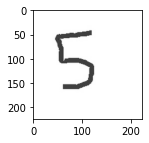

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

path="square.jpg"
img = cv2.imread(path)
# img=img/255
# img
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.show()

In [39]:
img.shape

(224, 224, 3)

In [ ]:
# img1 =transform(img)
# plt.figure(figsize=(2,2))
# plt.imshow(img1)
# plt.show()

In [40]:
with torch.no_grad():
  img1 =transform(img)
  print(img1.shape)
  img1 = torch.unsqueeze(img1, 0)
  print(img1.shape)
  img1 = img1.to(device)
  pred = features_model(img1)

TypeError: ignored

In [ ]:
with torch.no_grad():
  pred = torch.squeeze(pred)
  pred.shape
  result = classifier_model_noPrivate(pred)

In [ ]:
# airplane , automobile , bird , cat , deer , dog , frog , horse , ship , truck
result

tensor([-0.6152, -0.9731,  0.9780,  0.8272,  0.6324,  0.3651,  0.2295, -0.0307,
        -1.0381, -1.1767], device='cuda:0')